In [1]:
%matplotlib inline
from scipy import *
from scipy import integrate

import matplotlib
from classy import Class

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import ellipk # Elliptic integral
from scipy.special import iv # Modified Bessel function of the first kind of real order I_0
from scipy.special import kn # Modified Bessel function of the second kind of integer order n K_0


In [2]:
#####################################################
#
# Environment part          !!!!!NOW = Sputtering Al
#
#####################################################
global freq
freq = range(0,2001)              # list frequency (GHz)
global omega
omega = [0]*2001
i = 0
while i in range(0,2001):
    omega[i] = 2.0*pi*freq[i]*(10**9)
    i = i+1

global h_bar
global k_B
global mu_0
global epsilon_0
global T
global T_c
h_bar = 1.05457173*10**(-34)      # 1.05457173 × 10-34 m^2 kg / s   6.58211928(15)×10−16 eV·s
k_B = 1.3806488*10**(-23)         # 1.3806488×10−23 J|K-1  8.6173324×10-5 eV|K−1 
mu_0 = 4*pi*10**(-7)              # 4*pi*10**(-7)  1.25663706
epsilon_0 = 8.854187817*10**(-12) # 8.854187817*10**(-12)
T = 0.1                           # Kelvin
T_c = 1.2                      # Kelvin

Rho_c = 0.8 * 10**(-8)            # (Ohm m) MBE(0.1*10^-8) Sputtering(2*10^-8)
Rho_g = 0.8 * 10**(-8)            # (Ohm m) MBE(0.1*10^-8) Sputtering(2*10^-8)
global sigma_cn
global sigma_gn
global delta_0
global delta_T
global Thickness
sigma_cn = 1/Rho_c                # Normal state metal conductivity Al_bulk=3.56*10**7 (S/m)
sigma_gn = 1/Rho_g                # Normal state metal conductivity Al_bulk=3.56*10**7 (S/m)
delta_0 = 269.16566376*10**(-25)#1.674*k_B * T_c #+ 0*1j        # Calculation of delta_0 from Tc relation of BCS (eV)
Thickness = 40 *10**(-9)        # (m)
T_C = Thickness
T_G = Thickness

#delta_T = 177.0*10**(-6)          # Al (eV)

global epsilon
global CPW_C
global CPW_G
global ditangent
epsilon = 11.9                    # Dielectronic paramter of material
CPW_C = 3.0 *10**(-6)             # Width of CPW central trace (m)
CPW_G = 2.0 *10**(-6)             # Width of CPW gap (m)
ditangent = 0.005
dithickness = 400.0*10**(-6)

# Elliptic integral part
global k
global K_k
global k_prime
global K_k_prime
k = CPW_C / (CPW_C+CPW_G*2)       # CPW k parameter
k_1 = np.sinh(pi*CPW_C/4/dithickness)/np.sinh(pi*(CPW_C+2*CPW_G)/4/dithickness)
k_prime = np.sqrt(1-k*k)          # CPW k_prime parameter
k_1_prime = np.sqrt(1-k_1*k_1) 
K_k = ellipk(k*k)                 # The definition of elliptic integral function is different. In scipy it is m number, but here is modulus k
K_k_prime = ellipk(k_prime*k_prime)
K_k_1 = ellipk(k_1*k_1)
K_k_1_prime = ellipk(k_1_prime*k_1_prime)

In [3]:
#####################################################
#
# CPW part
#
#####################################################
def CPWIMP(CPW_C, CPW_G):
    # Inductance, capcitance and impedance
    L_g = mu_0*K_k_prime/K_k/4.0 # Geometric inductance
    L_k = 0.0
    L = L_g + L_k
    epsilon_eff = (1.0+epsilon)/2.0
    C_l = 4.0*epsilon_0*epsilon_eff*K_k/K_k_prime
    global Z
    Z = np.sqrt(L/C_l)
    print Z
CPWIMP(CPW_C, CPW_G)

51.5570509213


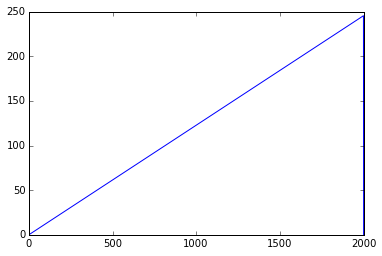

In [4]:
#####################################################
#
# CPW Dielectric loss Attenuation factor part
#
#####################################################
alpha_d = [0]*2001
q = 0.5 * K_k_prime*K_k_1/K_k_1_prime/K_k # filling factor
for f in range(1,2000):
    alpha_d[f] = pi/(299792458.0/(freq[f]*10**9))*epsilon/np.sqrt((1.0+epsilon)/2.0)*q*np.tan(ditangent)
plt.plot(freq,alpha_d)

In [5]:
#####################################################
#
# MB part
#
#####################################################
global fr
fr = 1
global sigma_1_1
global sigma_1_2
global sigma_1
global sigma_2
global sigma_n
global Z_s
global R_s
global L_s
global sigma_22
sigma_1_1 = [0]*2001
sigma_1_2 = [0]*2001
sigma_1 = [0]*2001
sigma_2 = [0]*2001
sigma_n = [0]*2001
Z_s = [0]*2001
R_s = [0]*2001
L_s = [0]*2001
sigma_22 = [0]*2001


for fr in range(1, 1500):
    
    def f(E):
        if E/k_B/T > 709:
            return 0
        else:
            return 1.0/(np.exp(E/(k_B *T)) + 1.0)
    def g1(E):
        return (E**2 + delta_0**2 + h_bar*omega[fr]*E) / ((E**2-delta_0**2)**0.5*((E+h_bar*omega[fr])**2-delta_0**2)**0.5)
    def g1_1(E):
        if h_bar*omega[fr] > 2*delta_0:
            return (E**2 + delta_0**2 + h_bar*omega[fr]*E) / ((E**2-delta_0**2)**0.5*((E+h_bar*omega[fr])**2-delta_0**2)**0.5)
        else:
            return 0
    def g2(E):
        return (E**2 + delta_0**2 + h_bar*omega[fr]*E) / ((delta_0**2-E**2)**0.5*((E+h_bar*omega[fr])**2-delta_0**2)**0.5)
    sigma_1_1i = lambda E: (2.0/h_bar/omega[fr]) * (f(E)-f(E+h_bar*omega[fr])) * g1(E)
    sigma_1_2i = lambda E: (1.0/h_bar/omega[fr]) * (1.0-2.0*f(E+h_bar*omega[fr])) * g1_1(E)
    sigma_1_1[fr] = integrate.quad(sigma_1_1i, delta_0, 656*k_B*T)
    sigma_1_2[fr] = integrate.quad(sigma_1_2i, min(delta_0-h_bar*omega[fr], -delta_0), -delta_0)
    sigma_1[fr] = sigma_1_1[fr][0] - sigma_1_2[fr][0]
    sigma_2i = lambda E: (1.0/h_bar/omega[fr]) * (1.0-2.0*f(E+h_bar*omega[fr])) * g2(E)
    sigma_22[fr] =  integrate.quad(sigma_2i, max(delta_0-h_bar*omega[fr], -delta_0), delta_0)
    sigma_2[fr] =sigma_22[fr][0]
    
for fr in range(1, 1499):
    sigma_n[fr] = (sigma_1[fr] - sigma_2[fr]*1j)*sigma_gn
    Z_s[fr] = np.sqrt(mu_0*omega[fr]*1j/sigma_n[fr])*1.0/np.tanh(Thickness * np.sqrt(1j*mu_0*omega[fr]*sigma_n[fr]))
    R_s[fr] = Z_s[fr].real
    L_s[fr] = Z_s[fr].imag
    #Z_sg = np.sqrt(mu_0*omega[fr]*1j/sigma_gn)*1.0/np.tanh(T_G * np.sqrt(mu_0*omega*sigma_gn))
print sigma_1[7],sigma_2[7]

3.66542348579e-08 18.197328028


/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


3.66542348579e-08


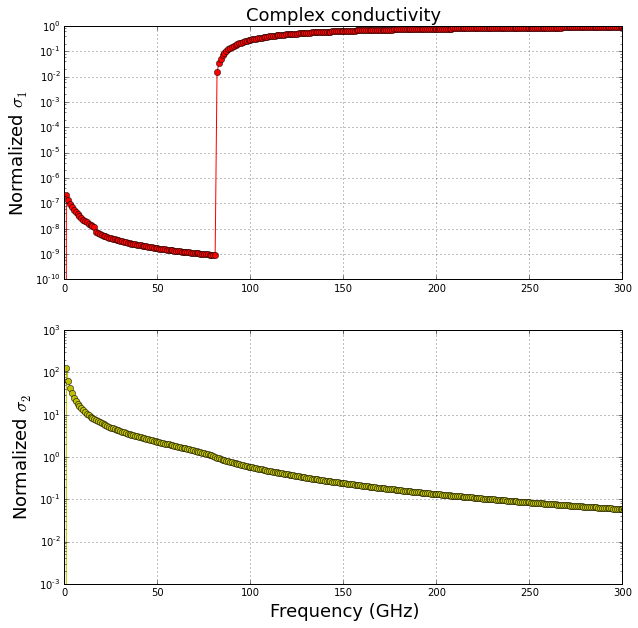

In [6]:
####################################
#
# Plotting MB Complex conductivity
#
####################################
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(freq, sigma_1,'ro-')
plt.title('Complex conductivity', fontsize=18)
plt.ylabel('Normalized $\sigma_1$', fontsize=18)
plt.yscale("log")
plt.xlim(0,300)
plt.grid(True)

#plt.figure(figsize=(8,4))
plt.subplot(2, 1, 2)
plt.plot(freq, sigma_2,'yo-')
plt.ylabel('Normalized $\sigma_2$', fontsize=18)
plt.xlabel('Frequency (GHz)', fontsize=18)
plt.yscale("log")
plt.xlim(0,300)
plt.grid(True)

print sigma_1[7]

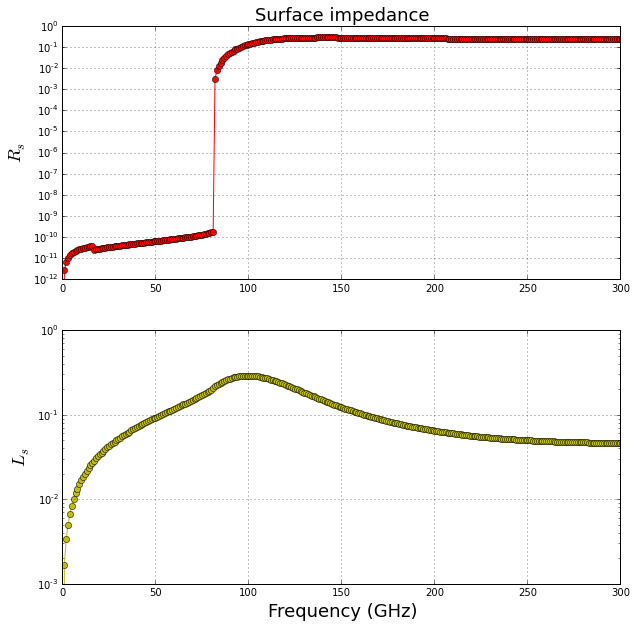

In [7]:
####################################
#
# Plotting MB Complex conductivity
#
####################################
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(freq, R_s,'ro-')
plt.title('Surface impedance', fontsize=18)
plt.ylabel('$R_s$', fontsize=18)
plt.yscale("log")
plt.xlim(0,300)
plt.grid(True)

#plt.figure(figsize=(8,4))
plt.subplot(2, 1, 2)
plt.plot(freq, L_s,'yo-')
plt.ylabel('$L_s$', fontsize=18)
plt.xlabel('Frequency (GHz)', fontsize=18)
plt.yscale("log")
plt.xlim(0,300)
plt.grid(True)

In [8]:
#####################################################
#
# CPW Conductor loss Attenuation factor part
#
#####################################################
global alpha
global power_attenuation
power_attenuation = [0]*2001
alpha = [0]*2001
tendb = [0]*2001
threedb = [0]*2001
if (T_C < CPW_C/20.0) and (k<0.8):
    g_c = 1.0/(4.0*CPW_C*(1.0-k*k)*(K_k**2.0))*(pi+np.log(4.0*pi*CPW_C/T_C)-k*np.log((1.0+k)/(1.0-k)))
    g_g = k/(4.0*CPW_C*(1.0-k*k)*(K_k**2.0))*(pi+np.log(4.0*pi*(CPW_C+2*CPW_G)/T_G)-(1.0/k)*np.log((1.0+k)/(1.0-k)))
else:
    print "error"

# Attenuation constant
for fr in range(1, 1499):
    alpha[fr] = (Z_s[fr].real*g_c + Z_s[fr].real*g_g)/(2.0 * Z)
    power_attenuation[fr] = 20.0*np.log10(e**(-alpha[fr]/ 1000.0))
    tendb[fr] = 1000/(alpha[fr]*log10(e))
    threedb[fr] = 300/(alpha[fr]*log10(e))
    
print g_c/(g_c + g_g)

0.720216945591


1234.85686492
1.86465748251
0.559397244752
7752.81176092


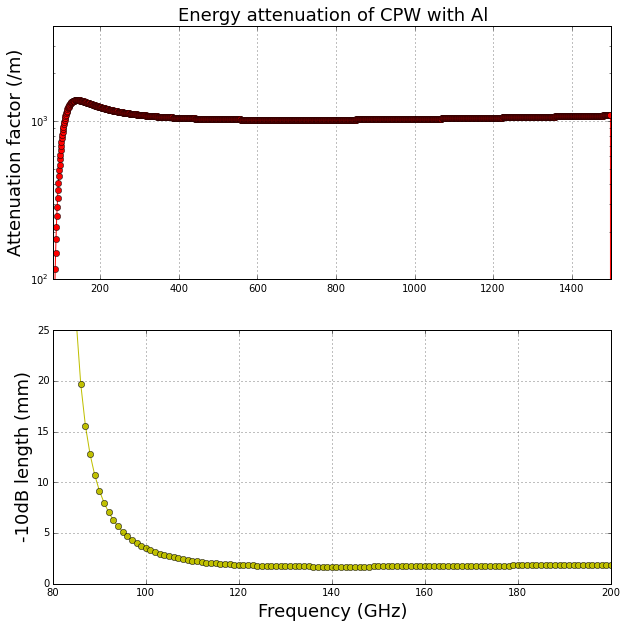

In [9]:
####################################
#
# Plotting
#
####################################
plt.figure(figsize=(10,10))


plt.subplot(2, 1, 1)
plt.plot(freq, alpha,'ro-')
plt.title('Energy attenuation of CPW with Al', fontsize=18)
plt.ylabel('Attenuation factor (/m)', fontsize=18)
plt.yscale("log")
plt.xlim(80,1499)
plt.ylim(100,4000)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(freq, tendb,'yo-')
plt.ylabel('-10dB length (mm)', fontsize=18)
plt.xlabel('Frequency (GHz)', fontsize=18)
#plt.yscale("log")
plt.xlim(80,200)
plt.ylim(0,25)
plt.grid(True)

print alpha[120]
print tendb[120]
print threedb[120]
print 1000/0.297/np.log10(e)

In [49]:
#####################################################
#
# Integration region analysis part
#
#####################################################
global fr
fr =1
# Mattis Bardeen
def f(E):
    if E/k_B/T > 709:
        return 0
    else:
        return 1.0/(np.exp(E/(k_B *T)) + 1.0)

#def f1(E):
#    return (f(E)-f(E+h_bar*omega[120]))

def g1(E):
    if h_bar*omega[fr] > 2*delta_0:
        return (E**2 + delta_0**2 + h_bar*omega[fr]*E) / ((E**2-delta_0**2)**0.5*((E+h_bar*omega[fr])**2-delta_0**2)**0.5)
    else:
        return 0
def g2(E):
    return (E**2 + delta_0**2 + h_bar*omega[fr]*E) / ((delta_0**2-E**2)**0.5*((E+h_bar*omega[fr])**2-delta_0**2)**0.5)
#sigma_2 = lambda E: (1/h_bar/omega[120]) * (1-2*f(E+h_bar*omega[120])) * g2(E)
#print integrate.quad(sigma_2, max(delta_0-h_bar*omega[120], -delta_0), delta_0)

qqq = lambda E: f1(E)
qqqq = lambda E: ((1.0 + e**(E/k_B/T))**(-1))
aaa = lambda E: 2.0/h_bar/omega[fr] * (f(E)-f(E+h_bar*omega[fr])) * g1(E)
bbb = lambda E: (1.0/h_bar/omega[fr]) * (1-2*f(E+h_bar*omega[fr])) * g1(E)

print delta_0
print 10.05*k_B*T # 10.05 minimum value for >delta_0
print '\n'
#print integrate.quad(f, delta_0, 766*k_B*T)
#print integrate.quad(f, delta_0, delta_0+18.05*k_B*T)
print integrate.quad(f, delta_0, 765*k_B*T) # 765 can make integration get maximum value
#print integrate.quad(qqqq, delta_0, 710*k_B*T) # 710 is the maximum value for no error
#print integrate.quad(f1, delta_0,  765*k_B*T) # 765 can make integration get maximum value

print '\n'
print integrate.quad(aaa, delta_0, 656*k_B*T) # 656 can make integration get maximum value
print integrate.quad(aaa, delta_0, 657*k_B*T)
print '\n'
print g1(-1.1*delta_0), h_bar*omega[fr]*(-1.1*delta_0), 1.21*delta_0**2+delta_0**2
print integrate.quad(bbb, min(delta_0-h_bar*omega[fr], -delta_0), -delta_0)

#print (1.0/h_bar/omega[fr]) * (1.0-2*f(-1.1*delta_0+h_bar*omega[fr])) * g1(-1.1*delta_0)
#print 1.0-2*f(-1.1*delta_0+h_bar*omega[fr]), g1(-1.1*delta_0), (-1.1*delta_0)**2 + delta_0**2 + h_bar*omega[fr]*(-1.1*delta_0)

2.6916566376e-23
1.387552044e-23


(4.7931095093004436e-33, 9.37389674500927e-33)


(0.0, 0.0)
(0.0, 0.0)


0 -1.961861464e-47 1.6011484155e-45
(-0.0, 0.0)


In [7]:
#####################################################
#
# Complex gap MB part
#
#####################################################
print g_c, g_g

350867.458734 135966.743106


In [ ]:
#####################################################
#
# MS part
#
#####################################################
wide = 
high = 
msthickness = 

In [ ]:
freq_r = 
length = 299792458.0 / 4.0 / freq_r *np.sqrt(2/(1+epsilon)) ## Mazin DT p41
CPW_C = 3 * 10**(-6) ## 3um
thickness = 50 * 10**(-9) ## 50nm
area = thickness * CPW_C
volume = area * length

L_g = mu_0*K_k_prime/K_k/4.0 # Geometric inductance, 
L_k = 


freq = range(10,10001)
sigma_N = 

N_0 = 1.72*10**10 * 10**18 / (1.6*10**(-19)) ## Visser DT p116
n_qp = 2 * N_0 *np.sqrt(2*pi*k_B*T*delta_0)*e**(-delta_0/k_B/T) ## Visser DT p16
N_qp = n_qp * volume ## Visser DT p16
tau_0 = 440 * 10*(-9) ## 440ns, Barends DT p23
tau_qp = tau_0 / n_qp * N_0 *(k_B*T_c)**3/2/delta_0**2 ## Visser DT p25
for i in range(10,10001):
    omegal[i] = 2.0*pi*freq[i]



In [ ]:
for fr in range(10,10001):
    sigma_1[fr] = (4.0*delta_0/h_bar/omegal[fr]) * (e**(-delta_0/k_B/T)) * (kn(0, h_bar*omegal[fr]/2.0/k_B/T)) * np.sinh(h_bar*omegal[fr]/2.0/k_B/T)
    sigma_2[fr] = (pi*delta_0/h_bar/omegal[fr]) * (1.0-(e**(-delta_0/k_B/T))) * (e**(-h_bar*omegal[fr]/2.0/k_B/T)) * (iv(0, h_bar*omegal[fr]/2.0/k_B/T))
    
    modulus_sigma[fr] = np.sqrt(sigma_1[fr]**2 + sigma_2[fr]**2) / sigma_N
    
    dsigma1dnqp[fr] = sigma_N / N_0 / h_bar / omegal[fr] * np.sqrt(2.0*delta_0/pi/k_B/T)(kn(0, h_bar*omegal[fr]/2.0/k_B/T)) * np.sinh(h_bar*omegal[fr]/2.0/k_B/T)
    dsigma2dnqp[fr] = sigma_N / N_0 / h_bar / omegal[fr] / 2.0 *(-1*pi) * (1.0 + 2*np.sqrt(2.0*delta_0/pi/k_B/T)*(e**(-h_bar*omega[fr]/2.0/k_B/T)) * (iv(0, h_bar*omegal[fr]/2.0/k_B/T)))
    
    mplambda[fr] = 1 / np.sqrt(mu_0 * omegal[fr]*sigma_2[fr]) ## Barends DT p40
    beta[fr] = 1 + (2*thickness/mplambda[fr])/np.sinh(2*thickness/mplambda[fr]) ## Barends DT p41
    L_k[fr] = 
    alpha[fr] = L_k[fr] / (L_k[fr] + L_g)
    dAdnqp[fr] = -alpha[fr]*beta[fr]*Q_r[fr]/modulus_sigma[fr]/volume * dsigma1dnqp[fr]
    dthetadnqp[fr] = -alpha[fr]*beta[fr]*Q_r[fr]/modulus_sigma[fr]/volume * dsigma2dnqp[fr]
    

In [25]:
#####################################################
#
# Power part
#
#####################################################

temperature = np.linspace(0.12, 0.30, num=180)
print temperature[0]
P_eph = 480.0 * (temperature**5 - 0.12**5)
#plt.plot(temperature, P_eph)
#plt.yscale("log")

f_0 = 4.26302*10**9
length = 0.004 # 4mm Visser P99
alpha = 2000
beta = pi/2.0/length
gamma = alpha + 1j*beta
Z_0 = 120*pi/np.sqrt(epislon_eff)
Z_trl = 20 # 20 ohm Visser P99
omega = 2 * pi * f_0
C_g = 5 * 10**(-15)# 5fF Visser P99
P_readout = 2*10**(-9) # 2nW
V_source = np.sqrt(4*Z_trl *P_readout)
Z_L = 1/(1j*omega*C_g) + Z_0*tanh(gamma*length)
I_L = V_source / (Z_trl + 2*Z_L)
R_L = Z_L.real
P_diss = I_L**2*R_L
#plt.plot(temperature, P_diss)
print Z_L

0.12
(6.30000141794-7466.76971217j)


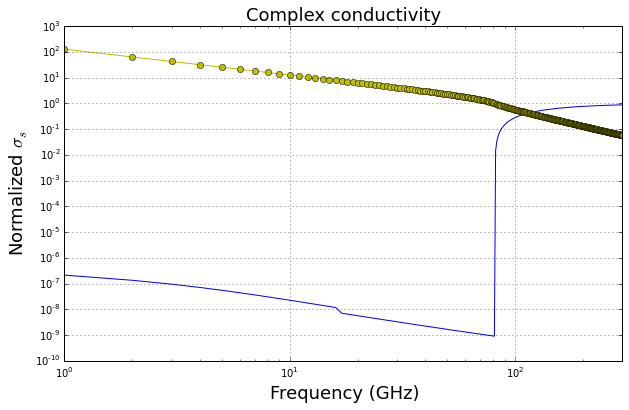

In [11]:
plt.figure(figsize=(10,6))
plt.plot(freq, sigma_1,'ro-')
plt.title('Complex conductivity', fontsize=18)

plt.plot(freq, sigma_2,'yo-')
plt.ylabel('Normalized $\sigma_s$', fontsize=18)
plt.xlabel('Frequency (GHz)', fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0,300)
plt.grid(True)

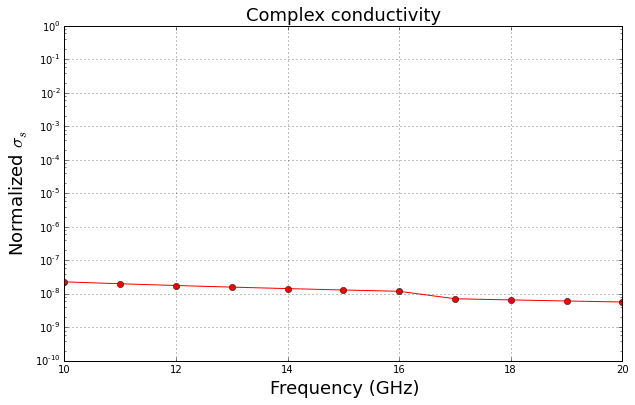

In [12]:
plt.figure(figsize=(10,6))
plt.plot(freq, sigma_1,'ro-')
plt.title('Complex conductivity', fontsize=18)

#plt.plot(freq, sigma_2,'yo-')
plt.ylabel('Normalized $\sigma_s$', fontsize=18)
plt.xlabel('Frequency (GHz)', fontsize=18)

plt.yscale("log")
plt.xlim(10,20)
plt.grid(True)